In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

def calc_lnam(x, y, uu, vv):
    # remeebr to input u and v transpose
    b = 1
    f = -1
    borders = b + 1
    L = np.zeros_like(uu)
    
    for i in range(borders, uu.shape[0] - borders):
        for j in range(borders, uu.shape[1] - borders):
            if not np.isnan(vv[i, j]):
                # Extract local values
                xlocal = x[i - b:i + b + 1, j - b:j + b + 1]
                ylocal = y[i - b:i + b + 1, j - b:j + b + 1]
                ulocal = uu[i - b:i + b + 1, j - b:j + b + 1]
                vlocal = vv[i - b:i + b + 1, j - b:j + b + 1]
                
                # Compute distances from centre
                center_idx = xlocal.shape[0]//2
  
                d_xcentre = xlocal - xlocal[center_idx, center_idx]
                d_ycentre = ylocal - ylocal[center_idx, center_idx]
                
                # Calculate cross and dot products
                cross = d_xcentre * vlocal - d_ycentre * ulocal
                dot = ulocal * d_xcentre + vlocal * d_ycentre
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                
                # Calculate L
                sumdp = np.sum(dot) + np.sum(produit)
                if sumdp != 0:
                    L[i, j] = np.sum(cross) / sumdp * np.sign(f)
    return L.T

In [3]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """
    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    # sigma -= rho0
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x/1000, y/1000, z


## Plots

In [4]:
def field_plot(fields):

    fig, axs = plt.subplots(6, 3, figsize=(10, 16))
    for r, (field_name, (Field, cmap, vmin, vmax)) in enumerate(fields.items()):
        # Top-down slice
        pcm = axs[r, 0].pcolor(x, y, Field[:, :, DEPTH_LVL].T, cmap=cmap, vmin=vmin, vmax=vmax)
        pcm.set_array(Field[:, :, DEPTH_LVL].T)
        axs[r, 0].set_xlabel('x (km)')
        axs[r, 0].set_ylabel('y (km)')
        cbar = fig.colorbar(pcm, ax=axs[r, 0], orientation='horizontal', location='top')
        cbar.ax.tick_params(axis='x', rotation=45)
        cbar.set_label(field_name)
    
        # Cross-section at middle y
        pcm = axs[r, 1].pcolor(x, z, Field[:, Field.shape[1] // 2, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
        pcm.set_array(Field[:, Field.shape[1] // 2, :].T)
        axs[r, 1].set_xlabel('x (km)')
        axs[r, 1].set_ylabel('Depth (m)')
        cbar = fig.colorbar(pcm, ax=axs[r, 1], orientation='horizontal', location='top')
        cbar.ax.tick_params(axis='x', rotation=45)
        cbar.set_label(field_name)
    
        # Cross-section at middle x
        pcm = axs[r, 2].pcolor(y, z, Field[Field.shape[0] // 2, :, :].T, cmap=cmap, vmin=vmin, vmax=vmax)
        pcm.set_array(Field[Field.shape[0] // 2, :, :].T)
        axs[r, 2].set_xlabel('y (km)')
        axs[r, 2].set_ylabel('Depth (m)')
        cbar = fig.colorbar(pcm, ax=axs[r, 2], orientation='horizontal', location='top')
        cbar.ax.tick_params(axis='x', rotation=45)
        cbar.set_label(field_name)
    
    plt.tight_layout()
    plt.show()

## No-Tilt No-Taper

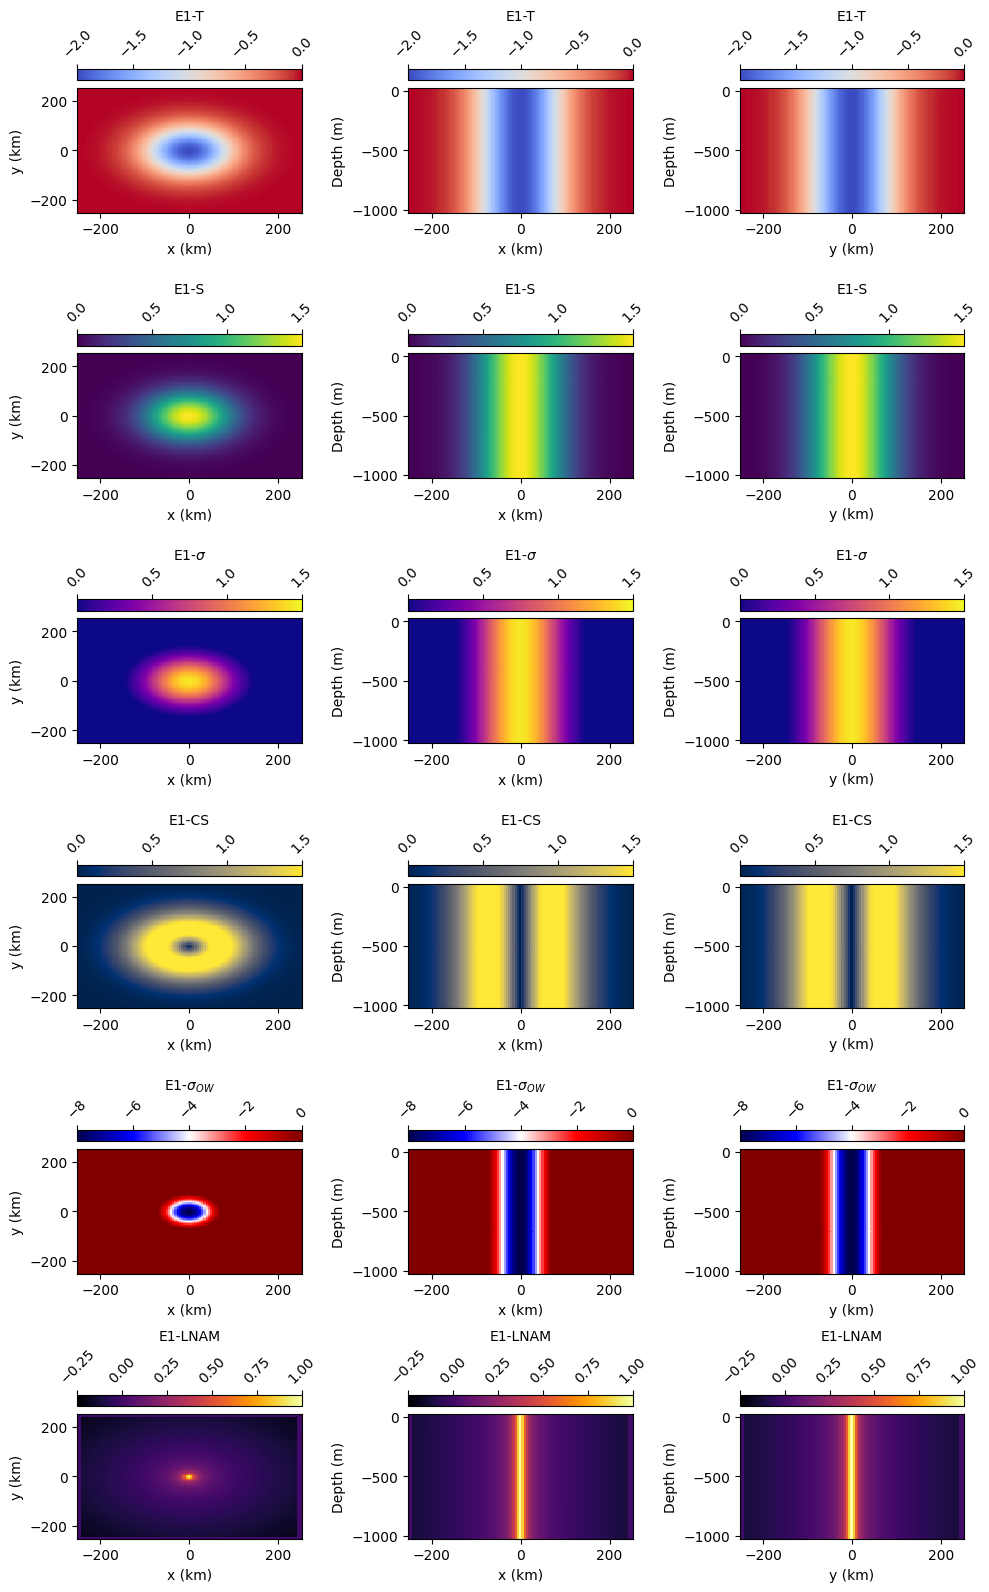

In [5]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

DEPTH_LVL = 5

fields = {
    "E1-T": (T, "coolwarm", -2, 0),
    "E1-S": (S, "viridis", 0, 1.5),
    r"E1-$\sigma$": (sigma, "plasma", 0, 1.5),
    "E1-CS": (np.hypot(U, V), "cividis", 0, 1.5),
    r"E1-$\sigma_{OW}$": (normalize_matrix(calc_ow(U, V, x[1]-x[0], y[1]-y[0])), "seismic", -8, 0), #-0.006, 0
    "E1-LNAM": (np.zeros_like(U), "inferno", -0.25, 1)
}

if "E1-LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["E1-LNAM"][0][:, :, k] = calc_lnam(X, Y, U[:, :, k].T, V[:, :, k].T)

field_plot(fields)

## Non-Tilt Tapered

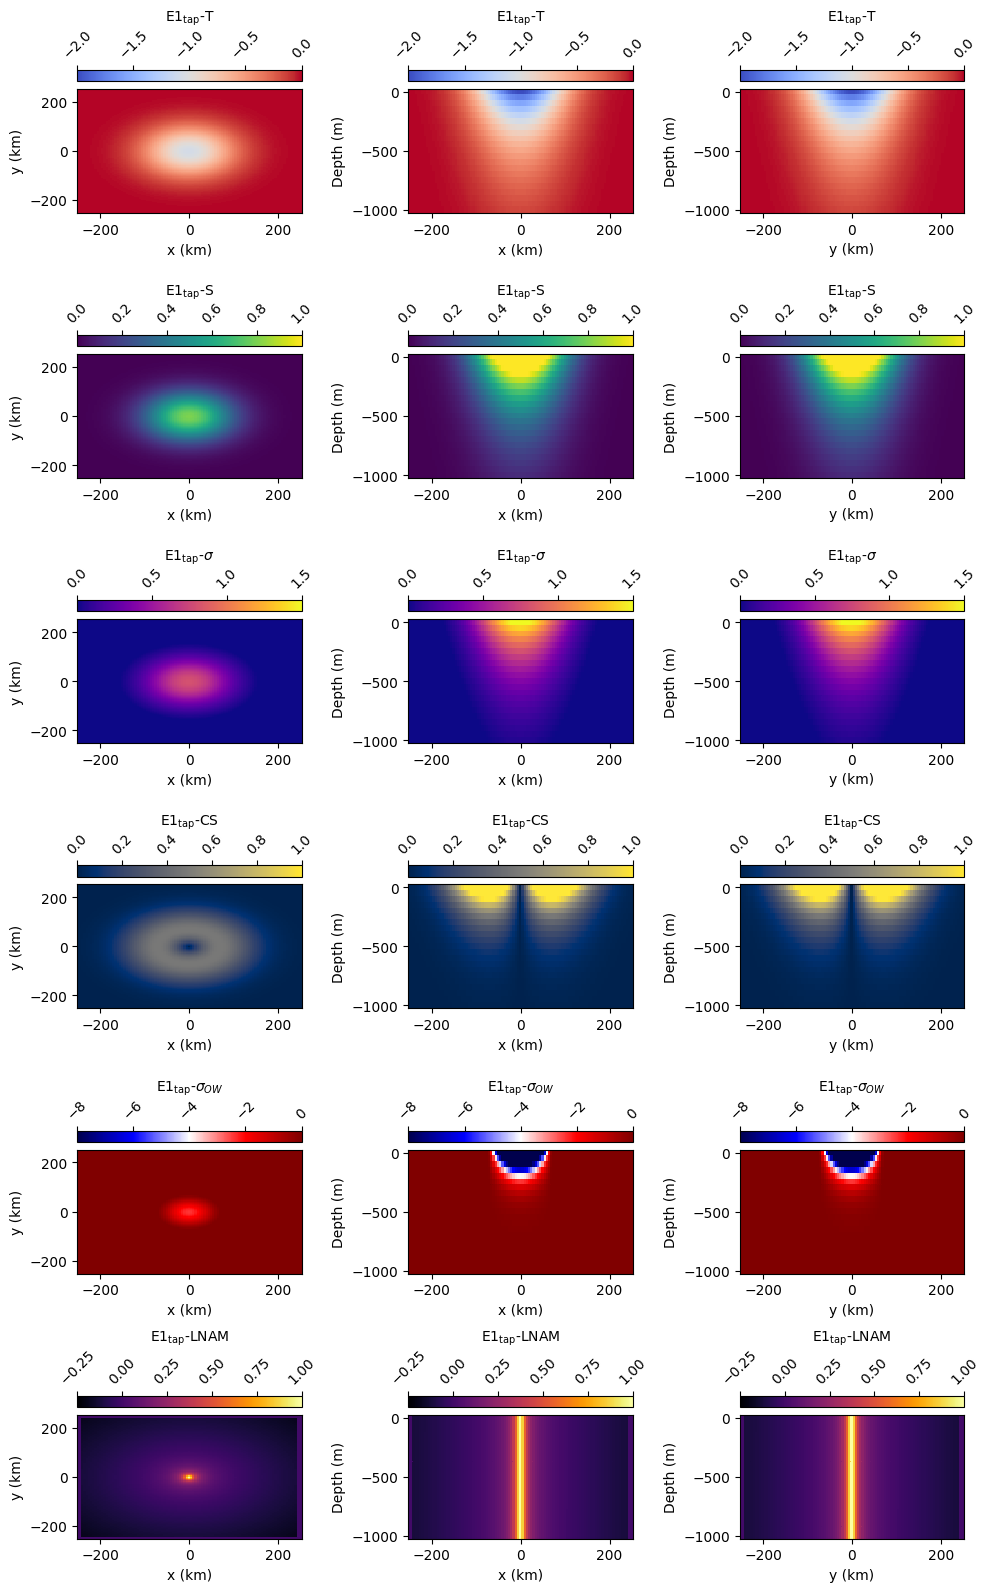

In [11]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)

DEPTH_LVL = 5

fields = {
    r"E1$_\text{tap}$-T": (T, "coolwarm", -2, 0),
    r"E1$_\text{tap}$-S": (S, "viridis", 0, 1),
    r"E1$_\text{tap}$-$\sigma$": (sigma, "plasma", 0, 1.5),
    r"E1$_\text{tap}$-CS": (np.hypot(U, V), "cividis", 0, 1),
    r"E1$_\text{tap}$-$\sigma_{OW}$": (normalize_matrix(calc_ow(U, V, x[1]-x[0], y[1]-y[0])), "seismic", -8, 0), #-0.005, 0
    r"E1$_\text{tap}$-LNAM": (np.zeros_like(U), "inferno", -0.25, 1)
}

if r"E1$_\text{tap}$-LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields[r"E1$_\text{tap}$-LNAM"][0][:, :, k] = calc_lnam(X, Y, U[:, :, k].T, V[:, :, k].T)
        
field_plot(fields)


## Tilt No-Taper

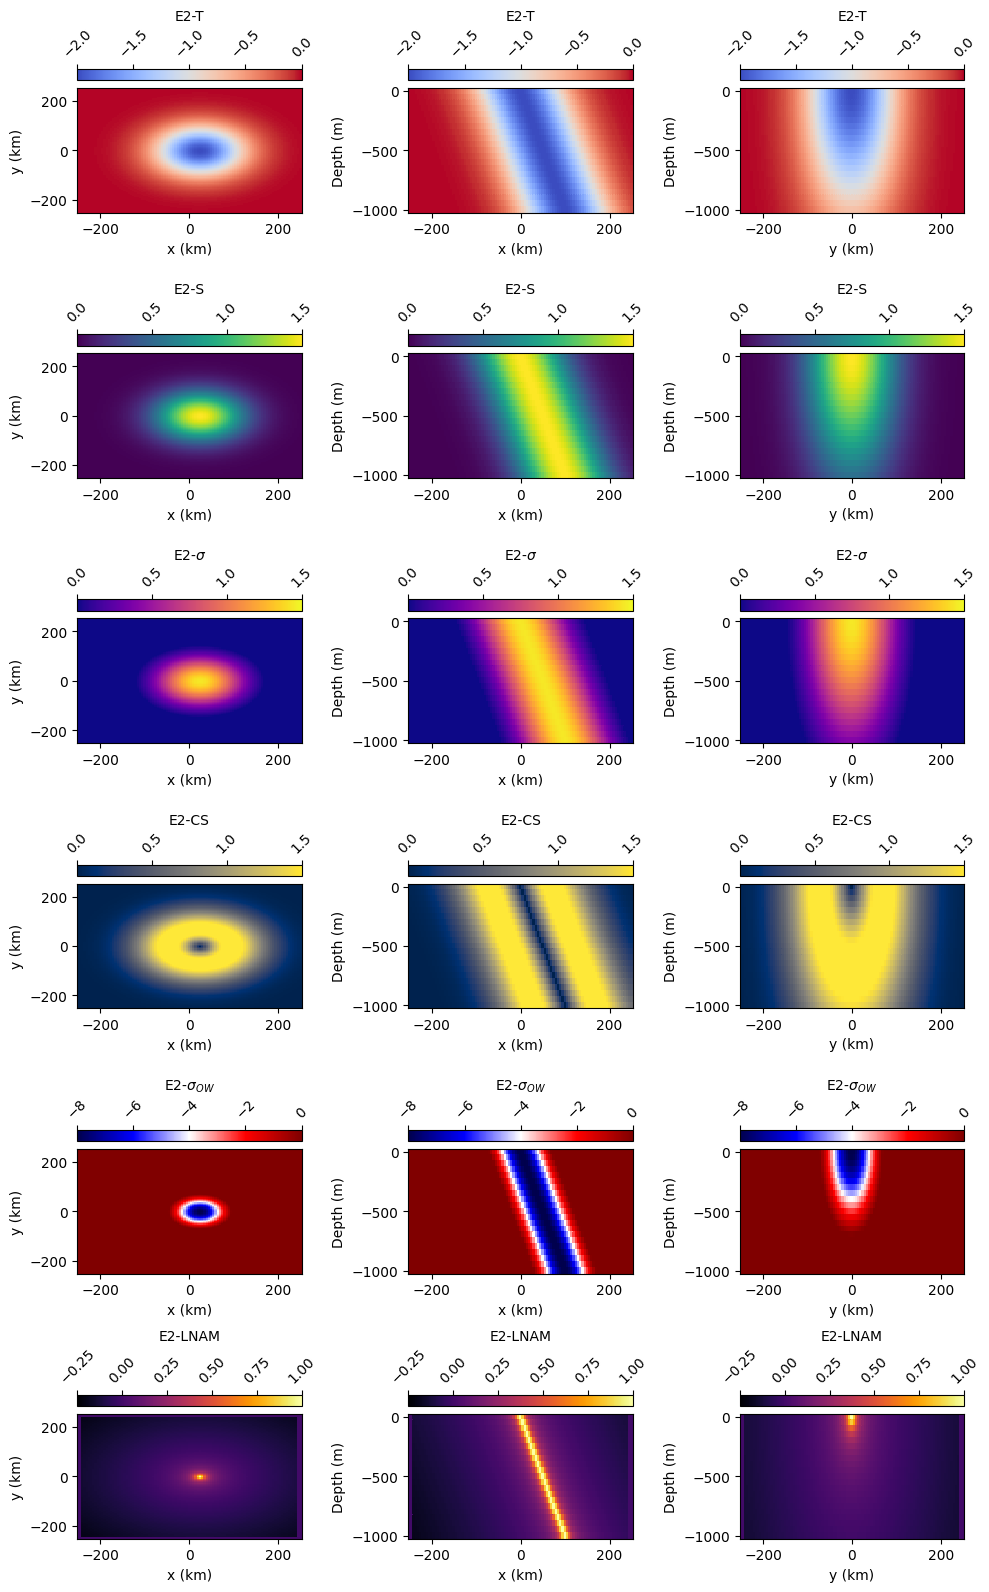

In [13]:
alpha_1 = (x[1]-x[0])*1000/(z[1]-z[0]) # tilt in x direction
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

DEPTH_LVL = 5

fields = {
    "E2-T": (T, "coolwarm", -2, 0),
    "E2-S": (S, "viridis", 0, 1.5),
    r"E2-$\sigma$": (sigma, "plasma", 0, 1.5),
    "E2-CS": (np.hypot(U, V), "cividis", 0, 1.5),
    r"E2-$\sigma_{OW}$": (normalize_matrix(calc_ow(U, V, x[1]-x[0], y[1]-y[0])), "seismic", -8, 0), #-0.006, 0
    "E2-LNAM": (np.zeros_like(U), "inferno", -0.25, 1)
}


if "E2-LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields["E2-LNAM"][0][:, :, k] = calc_lnam(X, Y, U[:, :, k].T, V[:, :, k].T)

field_plot(fields)


## Tilt Tapered

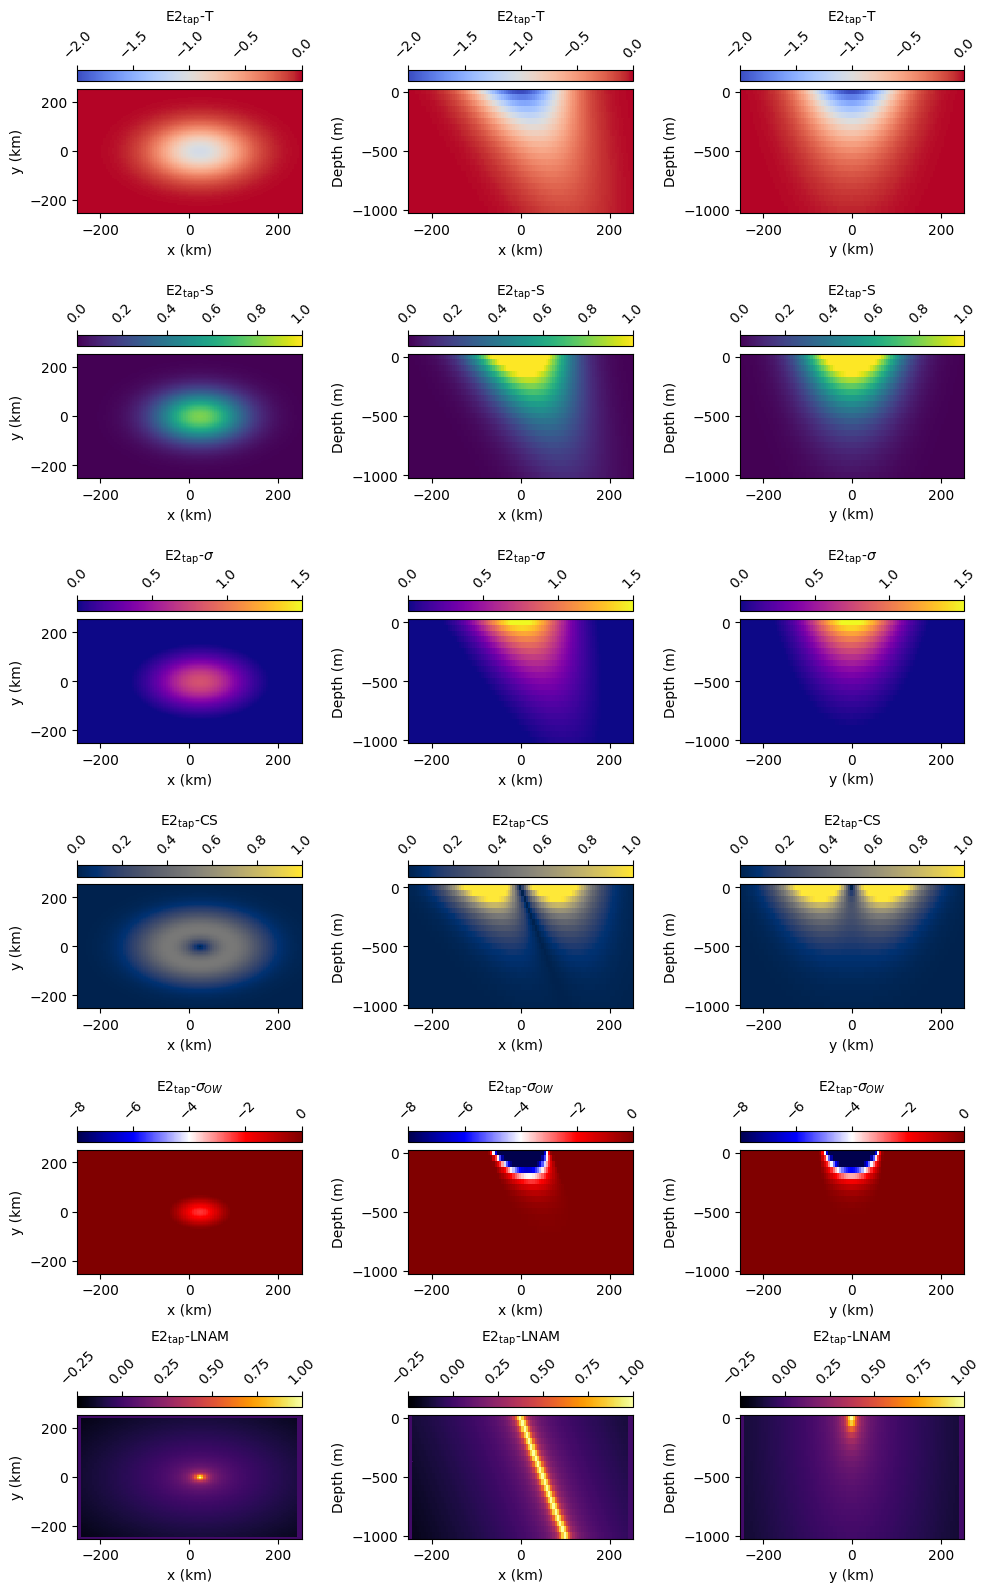

In [15]:
alpha_1 = (x[1]-x[0])*1000/(z[1]-z[0]) # tilt in x direction
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400, alpha_1=alpha_1)

DEPTH_LVL = 5

fields = {
    r"E2$_\text{tap}$-T": (T, "coolwarm", -2, 0),
    r"E2$_\text{tap}$-S": (S, "viridis", 0, 1),
    r"E2$_\text{tap}$-$\sigma$": (sigma, "plasma", 0, 1.5),
    r"E2$_\text{tap}$-CS": (np.hypot(U, V), "cividis", 0, 1),
    r"E2$_\text{tap}$-$\sigma_{OW}$": (normalize_matrix(calc_ow(U, V, x[1]-x[0], y[1]-y[0])), "seismic", -8, 0), #-0.005, 0
    r"E2$_\text{tap}$-LNAM": (np.zeros_like(U), "inferno", -0.25, 1)
}

if r"E2$_\text{tap}$-LNAM" in fields:
    X, Y = np.meshgrid(x, y)
    for k in range(U.shape[-1]):
        fields[r"E2$_\text{tap}$-LNAM"][0][:, :, k] = calc_lnam(X, Y, U[:, :, k].T, V[:, :, k].T)

field_plot(fields)

## OW Isosurface

In [9]:
def calc_ow(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std

/scratch/pbs.6155598.kman.restech.unsw.edu.au/ipykernel_1062363/3812153089.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


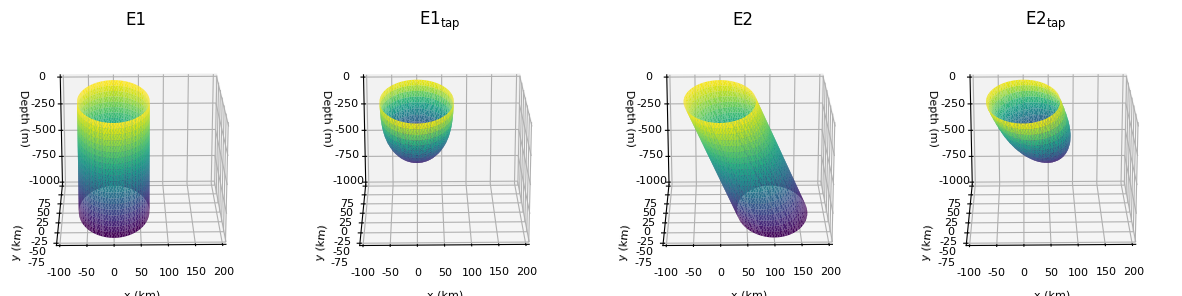

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

OW_THRESH = -.2

U, V, _, _, _, _, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx * 1000 / dz # tilt in x direction

U_tilt, V_tilt, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, _, _, _, _, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)

ow = calc_ow(U, V, x[1]-x[0], y[1]-y[0])
ow = normalize_matrix(ow)

ow_tilt = calc_ow(U_tilt, V_tilt, x[1]-x[0], y[1]-y[0])
ow_tilt = normalize_matrix(ow_tilt)

ow_tap = calc_ow(U_tap, V_tap, x[1]-x[0], y[1]-y[0])
ow_tap = normalize_matrix(ow_tap)

ow_tilt_tap = calc_ow(U_tilt_tap, V_tilt_tap, x[1]-x[0], y[1]-y[0])
ow_tilt_tap = normalize_matrix(ow_tilt_tap)

fig = plt.figure(figsize=(15, 13))

# Data for plots
datasets = [(ow, 'E1'), (ow_tap, r'E1$_\text{tap}$'), (ow_tilt, 'E2'), (ow_tilt_tap, r'E2$_\text{tap}$')]
axs = [fig.add_subplot(1, 4, i + 1, projection='3d') for i in range(4)]

# New tick positions and labels
new_xticks = [30, 40, 50, 60, 70, 80, 90]
new_xticklabels = x[new_xticks]
new_xticklabels = [round(x) for x in new_xticklabels]
new_yticks = [35, 40, 45, 50, 55, 60, 65]
new_yticklabels = y[new_yticks]
new_yticklabels = [round(y) for y in new_yticklabels]
new_zticks = [0, 5, 10, 15, 20]
new_zticklabels = np.flip(z[new_zticks])
new_zticklabels = [round(z) for z in new_zticklabels]

# Plotting isosurfaces
for ax, (data, title) in zip(axs, datasets):
    verts, faces, _, _ = measure.marching_cubes(np.flip(data, axis=2), OW_THRESH)
    ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, cmap='viridis', lw=1)
    ax.set(title=title, xlabel='x (km)', ylabel='y (km)', zlabel='Depth (m)')
    ax.xaxis.label.set_fontsize(8)
    ax.yaxis.label.set_fontsize(8)
    ax.zaxis.label.set_fontsize(8)
    ax.view_init(elev=20, azim=269)

    # Set new ticks and labels
    ax.set_xticks(new_xticks)
    ax.set_xticklabels(new_xticklabels, fontsize=8)
    ax.set_yticks(new_yticks)
    ax.set_yticklabels(new_yticklabels, fontsize=8)
    ax.set_zticks(new_zticks)
    ax.set_zticklabels(new_zticklabels, fontsize=8)

# Synchronize axis limits
lims = [ax.get_xlim() + ax.get_ylim() + ax.get_zlim() for ax in axs]
xmin, xmax = min(l[0] for l in lims), max(l[1] for l in lims)
ymin, ymax = min(l[2] for l in lims), max(l[3] for l in lims)
zmin, zmax = min(l[4] for l in lims), max(l[5] for l in lims)

for ax in axs:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

plt.tight_layout()
plt.show()


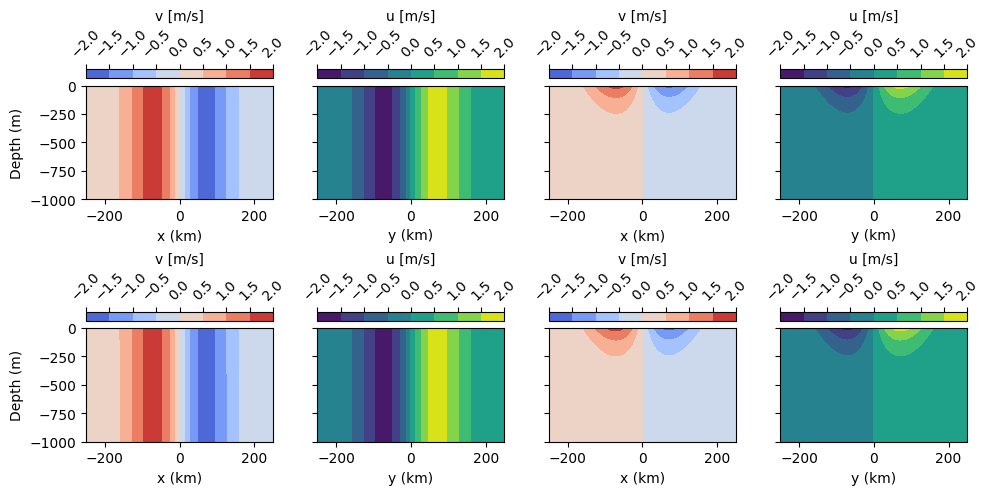

In [11]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)

modelled_data = {
    'Eddy0':{
        'Name': 'Untapered', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': 'Tapered', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'Tilting and Untapered', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': 'Tilting and Tapered', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']


fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]

    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()